# Predictive Analytics Individual Assignment

In [24]:
%pip install -q seaborn
%pip install -q xgboost
%pip install -q tensorflow

In [25]:
import os
from math import sqrt

# Third-party imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Download the Data

In [26]:
def load_insurance_data():
    url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
    print(f"Downloading insurance dataset from {url}...")

    response = requests.get(url)

    if response.status_code == 200:
        with open("insurance.csv", "wb") as file:
            file.write(response.content)
        print("Download completed!")

        return pd.read_csv("insurance.csv")

insurance = load_insurance_data()
print("Dataset loaded successfully!")
print("\nFirst five rows of the dataset:")
print(insurance.head())
print("\nDataset information:")
print(insurance.info())
print("\nBasic statistics:")
print(insurance.describe())

Download completed!
Dataset loaded successfully!

First five rows of the dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 7

# Data Cleaning

In [27]:
insurance_cleaned = insurance.copy()

# Check missing values
missing_values = insurance_cleaned.isnull().sum()
print(f"Missing values:\n{missing_values}")

# Remove duplicates
duplicates = insurance_cleaned.duplicated().sum()
if duplicates > 0:
    insurance_cleaned = insurance_cleaned.drop_duplicates().reset_index(drop=True)
    print(f"Removed {duplicates} duplicates")

# Use consistent formatting for categorical variables
categorical_columns = ['sex', 'smoker', 'region']
for col in categorical_columns:
    insurance_cleaned[col] = insurance_cleaned[col].str.lower()

# Check for outliers in numerical columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=insurance_cleaned[['age', 'bmi', 'children', 'charges']])
plt.title('Boxplot of Numerical Features')
plt.tight_layout()
plt.savefig('outliers_boxplot.png')
plt.close()

# Create datasets directory
os.makedirs('datasets', exist_ok=True)

insurance_cleaned.to_csv('datasets/insurance_cleaned.csv', index=False)
print("Data cleaning completed and saved")

Missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Removed 1 duplicates
Data cleaning completed and saved


# Exploratory Data Analysis


In [28]:
# Identify feature types
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children', 'charges']

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Categorical features: ['sex', 'smoker', 'region']
Numerical features: ['age', 'bmi', 'children', 'charges']


## Distribution of Target Variable (Charges)

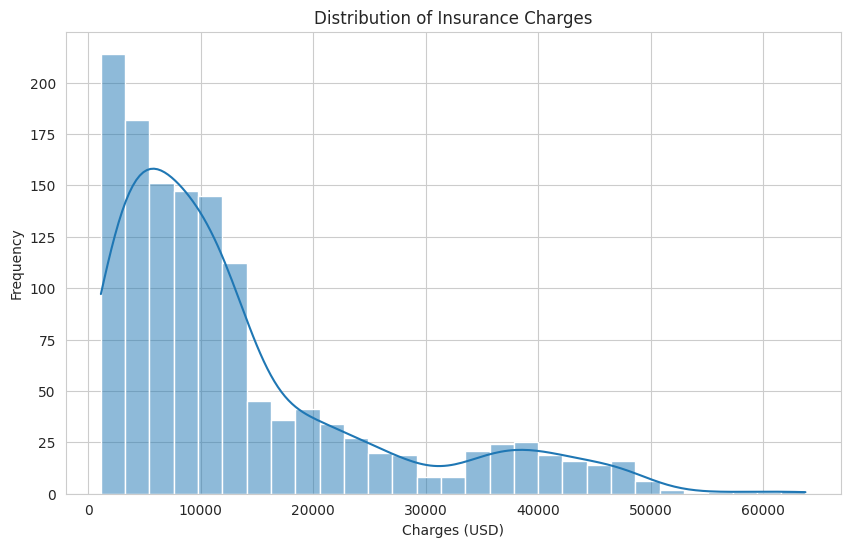

In [29]:
plt.figure()
sns.histplot(insurance_cleaned['charges'], kde=True)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges (USD)')
plt.ylabel('Frequency')
plt.savefig('target_distribution.png')
plt.show()

## Correlation Heatmap of Numerical Features

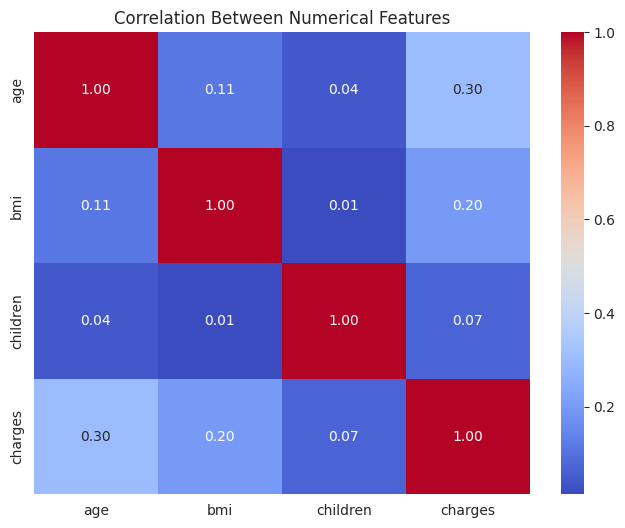

In [30]:
plt.figure(figsize=(8, 6))
correlation = insurance_cleaned[numerical_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Numerical Features')
plt.savefig('correlation_heatmap.png')
plt.show()

## Impact of Smoking on Charges

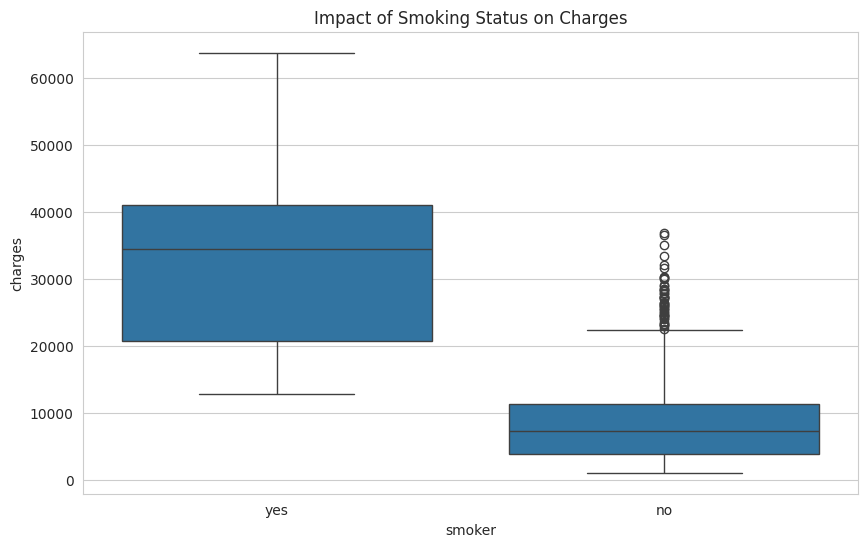

In [31]:
plt.figure()
sns.boxplot(x='smoker', y='charges', data=insurance_cleaned)
plt.title('Impact of Smoking Status on Charges')
plt.savefig('smoking_vs_charges.png')
plt.show()

## Age vs. Charges relationship

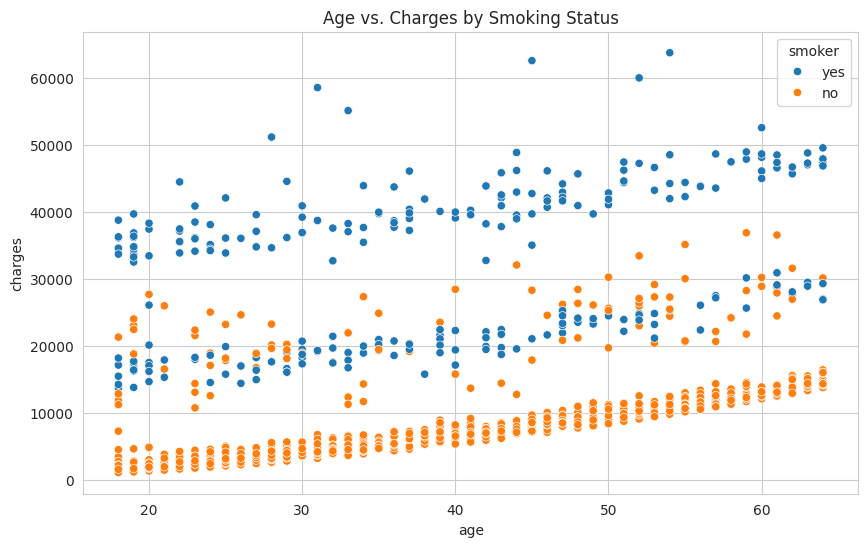

In [32]:
plt.figure()
sns.scatterplot(x='age', y='charges', hue='smoker', data=insurance_cleaned)
plt.title('Age vs. Charges by Smoking Status')
plt.savefig('age_vs_charges.png')
plt.show()

## BMI vs. Charges relationship

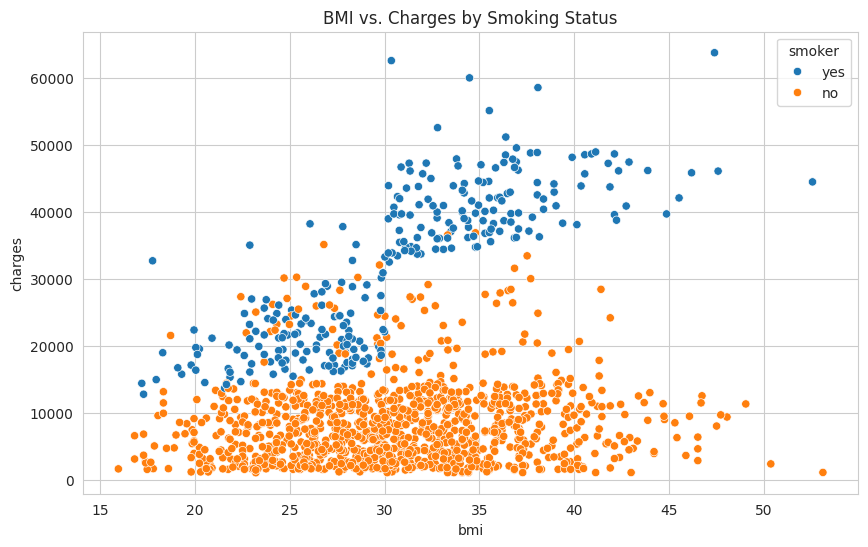

In [33]:
plt.figure()
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=insurance_cleaned)
plt.title('BMI vs. Charges by Smoking Status')
plt.savefig('bmi_vs_charges.png')
plt.show()

## Impact of Children and Region on Charges

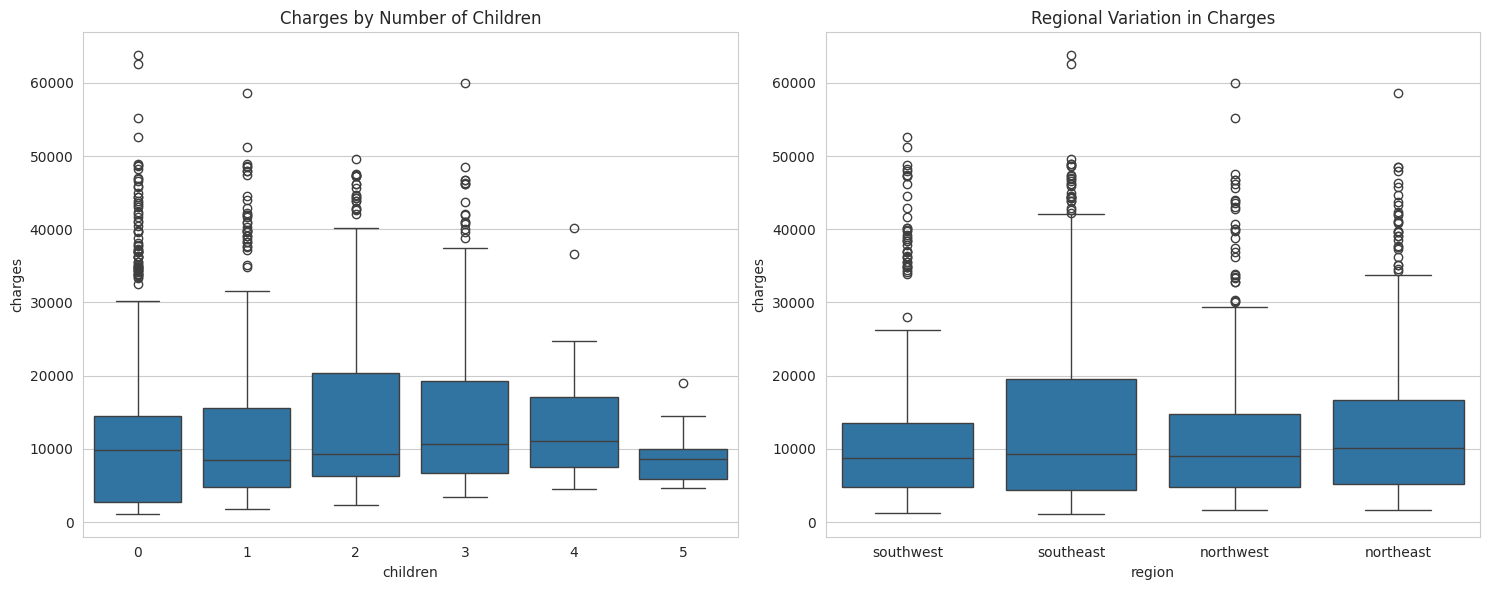

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x='children', y='charges', data=insurance_cleaned, ax=ax[0])
ax[0].set_title('Charges by Number of Children')
sns.boxplot(x='region', y='charges', data=insurance_cleaned, ax=ax[1])
ax[1].set_title('Regional Variation in Charges')
plt.tight_layout()
plt.savefig('children_region_charges.png')
plt.show()

## Summary statistics by categorical features

In [35]:
print("\n=== Summary Statistics by Key Categories ===")
print("\nCharges by Smoking Status:")
print(insurance_cleaned.groupby('smoker')['charges'].describe())
print("\nCharges by Region:")
print(insurance_cleaned.groupby('region')['charges'].describe())


=== Summary Statistics by Key Categories ===

Charges by Smoking Status:
         count          mean           std         min           25%  \
smoker                                                                 
no      1063.0   8440.660307   5992.973800   1121.8739   3988.883500   
yes      274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                50%           75%          max  
smoker                                          
no       7345.72660  11363.019100  36910.60803  
yes     34456.34845  41019.207275  63770.42801  

Charges by Region:
           count          mean           std        min          25%  \
region                                                                 
northeast  324.0  13406.384516  11255.803066  1694.7964  5194.322288   
northwest  324.0  12450.840844  11073.125699  1621.3402  4733.635288   
southeast  364.0  14735.411438  13971.098589  1121.8739  4440.886200   
southwest  325.0  12346.937377  11557.179101  1241.5650  4751

# Feature Engineering

In [36]:
insurance_features = insurance_cleaned.copy()

# BMI categories according to WHO standards
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

insurance_features['bmi_category'] = insurance_features['bmi'].apply(categorize_bmi)

# Age groups
def categorize_age(age):
    if age < 20:
        return 'teen'
    elif age < 35:
        return 'young_adult'
    elif age < 50:
        return 'middle_aged'
    elif age < 65:
        return 'senior'
    else:
        return 'elderly'

insurance_features['age_group'] = insurance_features['age'].apply(categorize_age)

# binary children feature
insurance_features['has_children'] = (insurance_features['children'] > 0).astype(int)

# Smoking and BMI interaction
insurance_features['smoker_bmi'] = insurance_features['bmi'] * (insurance_features['smoker'] == 'yes').astype(int)

# Age and smoking interaction
insurance_features['age_smoker'] = insurance_features['age'] * (insurance_features['smoker'] == 'yes').astype(int)

# Polynomial features for age and bmi (to capture non-linear relationships)
insurance_features['age_squared'] = insurance_features['age'] ** 2
insurance_features['bmi_squared'] = insurance_features['bmi'] ** 2

# Encoding categorical variables, One-hot encoding for region
region_dummies = pd.get_dummies(insurance_features['region'], prefix='region')
insurance_features = pd.concat([insurance_features, region_dummies], axis=1)

# Binary encoding for sex and smoker
insurance_features['is_male'] = (insurance_features['sex'] == 'male').astype(int)
insurance_features['is_smoker'] = (insurance_features['smoker'] == 'yes').astype(int)

# Log transform of charges (since we saw it was right-skewed)
insurance_features['log_charges'] = np.log(insurance_features['charges'])

# Display new features
print("Features after engineering:")
print(insurance_features.columns.tolist())

# Preview the engineered dataset
print("\nSample of engineered features:")
print(insurance_features.head())

Features after engineering:
['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'bmi_category', 'age_group', 'has_children', 'smoker_bmi', 'age_smoker', 'age_squared', 'bmi_squared', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'is_male', 'is_smoker', 'log_charges']

Sample of engineered features:
   age     sex     bmi  children smoker     region      charges bmi_category  \
0   19  female  27.900         0    yes  southwest  16884.92400   overweight   
1   18    male  33.770         1     no  southeast   1725.55230        obese   
2   28    male  33.000         3     no  southeast   4449.46200        obese   
3   33    male  22.705         0     no  northwest  21984.47061       normal   
4   32    male  28.880         0     no  northwest   3866.85520   overweight   

     age_group  has_children  ...  age_smoker  age_squared  bmi_squared  \
0         teen             0  ...          19          361   778.410000   
1         teen        

# Data Preparation

In [37]:
# Use the dataset from feature engineering
insurance_model = insurance_features.copy()

# Drop original categorical columns that we've already encoded
columns_to_drop = ['sex', 'smoker', 'region', 'bmi_category', 'age_group']
insurance_model = insurance_model.drop(columns=columns_to_drop)

# Define features and target
X = insurance_model.drop(columns=['charges', 'log_charges'])  # Using all features except the target
y = insurance_model['log_charges']  # Using log-transformed target based on EDA

# Split training and testing sets 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check shapes of train/test sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Identify numerical features for scaling
numerical_features = ['age', 'bmi', 'children', 'smoker_bmi',
                      'age_smoker', 'age_squared', 'bmi_squared']

# Create preprocessing pipeline with standardization for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Display feature names for reference later in the modeling
feature_names = list(X.columns)
print("Features to be used for modeling:", feature_names)

Training set shape: (1069, 14)
Testing set shape: (268, 14)
Features to be used for modeling: ['age', 'bmi', 'children', 'has_children', 'smoker_bmi', 'age_smoker', 'age_squared', 'bmi_squared', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'is_male', 'is_smoker']


# Model Development

## Linear Regression

Intercept: 6.0978, Coefficients shape: (14,)
Test RMSE (log scale): 0.3398
Test R²: 0.8756


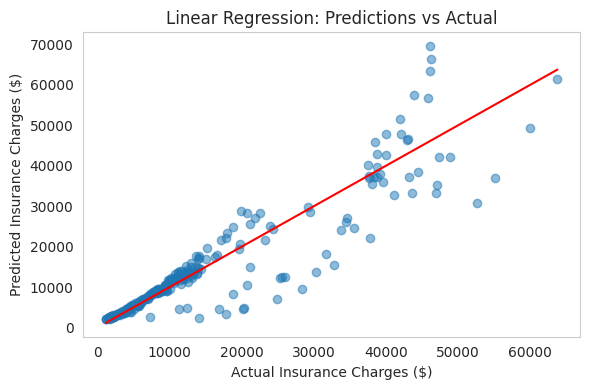


Top 5 coefficients:
is_smoker: 1.2194
is_male: -0.0831
children: 0.0820
region_northeast: 0.0708
has_children: 0.0621


In [38]:
# Train a simple Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print(f"Intercept: {lin_reg.intercept_:.4f}, Coefficients shape: {lin_reg.coef_.shape}")

# Make predictions
y_pred_test = lin_reg.predict(X_test)

# Calculate metrics
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print(f"Test RMSE (log scale): {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Convert predictions back to original scale if needed
if 'log_charges' in insurance_model.columns:
    y_test_original = np.exp(y_test)
    y_pred_test_original = np.exp(y_pred_test)
else:
    y_test_original = y_test
    y_pred_test_original = y_pred_test

# Plot predictions vs actual values
plt.figure(figsize=(6, 4))
plt.scatter(y_test_original, y_pred_test_original, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)], 'r-')

if 'log_charges' in insurance_model.columns:
    plt.xlabel('Actual Insurance Charges ($)')
    plt.ylabel('Predicted Insurance Charges ($)')
else:
    plt.xlabel('Actual Insurance Charges')
    plt.ylabel('Predicted Insurance Charges')

plt.title('Linear Regression: Predictions vs Actual')
plt.grid()
plt.tight_layout()
plt.show()

# Display top coefficients
coeffs = list(zip(feature_names, lin_reg.coef_))
coeffs.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nTop 5 coefficients:")
for feat, coef in coeffs[:5]:
    print(f"{feat}: {coef:.4f}")

## Random Forest

Random Forest Performance Metrics:
Mean Squared Error (MSE): 0.1338
Root Mean Squared Error (RMSE): 0.3658
Mean Absolute Error (MAE): 0.1910
R² Score: 0.8559


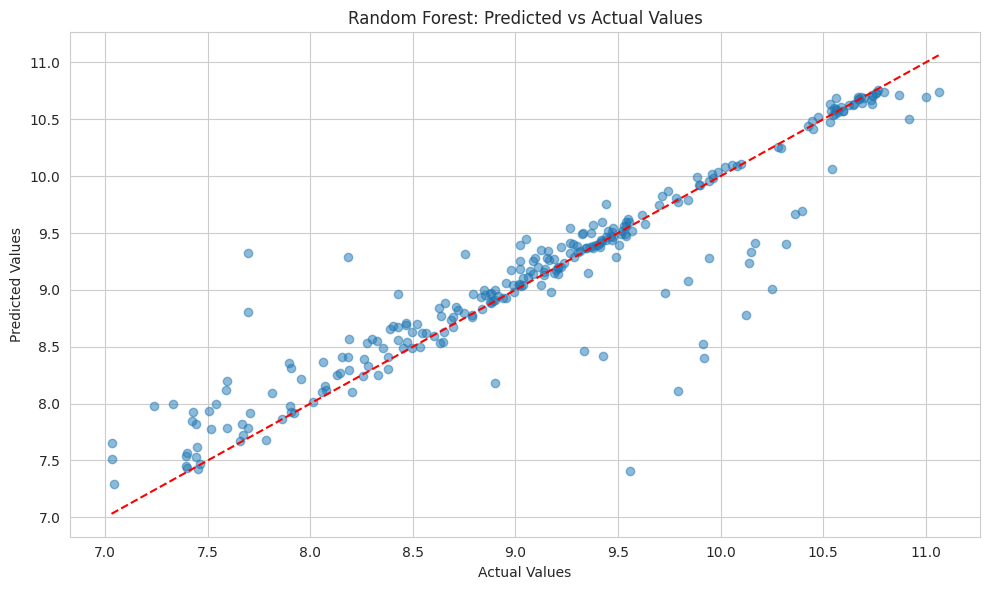

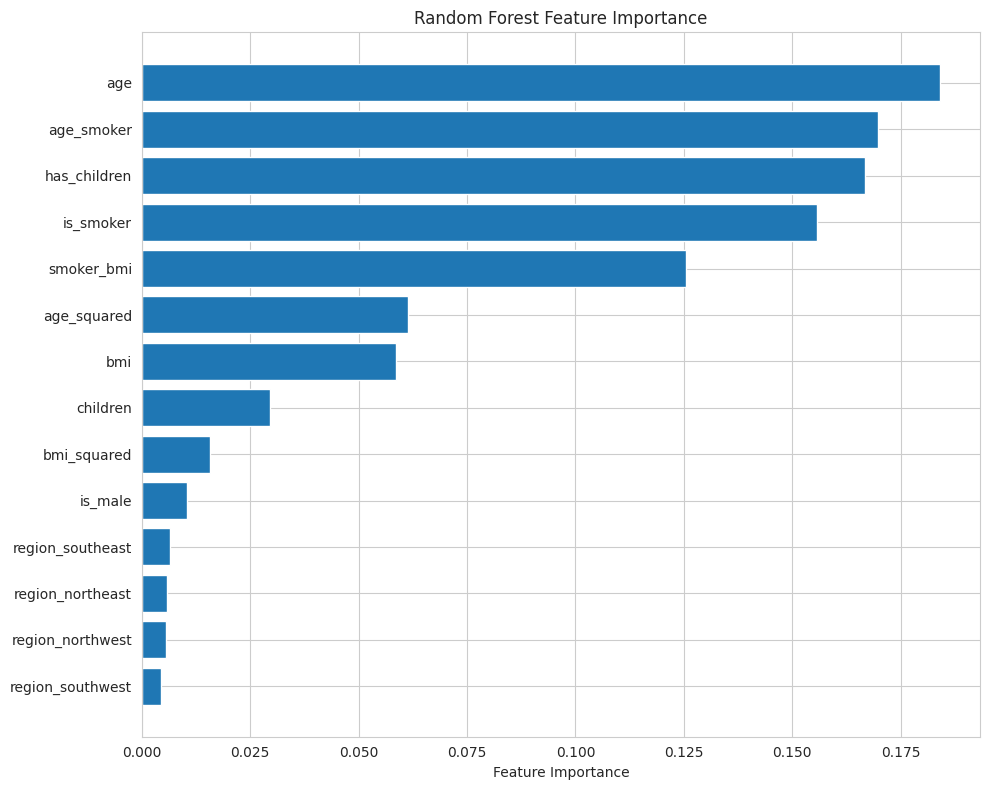

In [39]:
# Apply preprocessing to features
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert target to numpy array
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Create and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,        # Number of trees in the forest
    max_depth=None,          # Maximum depth of the trees
    min_samples_split=2,     # Minimum samples required to split an internal node
    min_samples_leaf=1,      # Minimum samples required at a leaf node
    max_features='sqrt',     # Number of features to consider for best split
    bootstrap=True,          # Whether bootstrap samples are used
    n_jobs=-1,               # Use all processors
    random_state=42          # For reproducibility
)

# Train the model
rf_model.fit(X_train_preprocessed, y_train_np)

# Make predictions
y_pred_rf = rf_model.predict(X_test_preprocessed)

# Calculate performance metrics
mse = mean_squared_error(y_test_np, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_pred_rf)
r2 = r2_score(y_test_np, y_pred_rf)

# Display metrics
print(f"Random Forest Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_rf, alpha=0.5)
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Predicted vs Actual Values')
plt.tight_layout()
plt.show()

# Visualize feature importances
feature_importances = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

## XGBoost

XGBoost RMSE (log scale): 0.4210
XGBoost R²: 0.8090
XGBoost RMSE (original scale): $6271.56
XGBoost R² (original scale): 0.7860


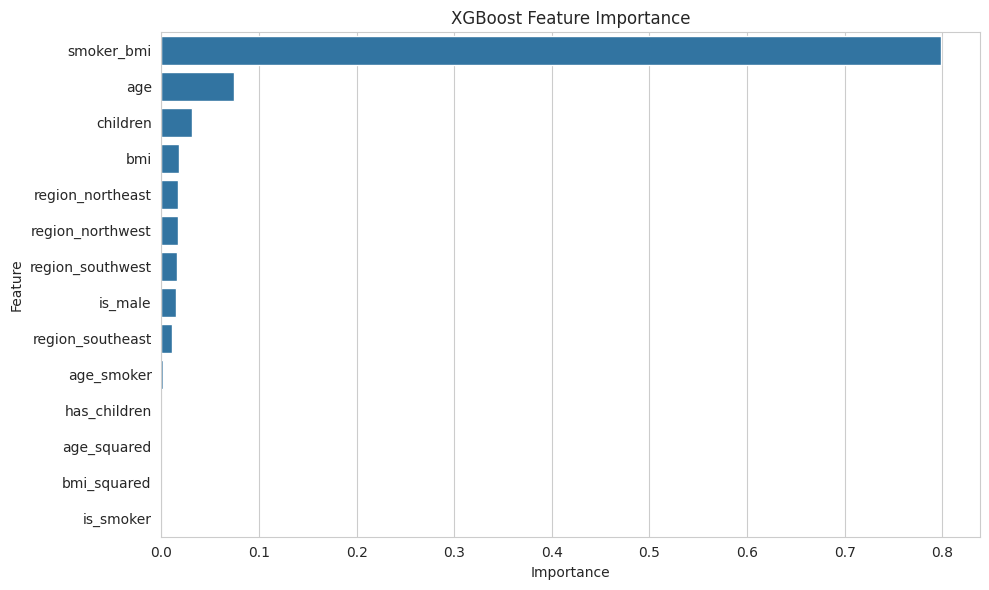

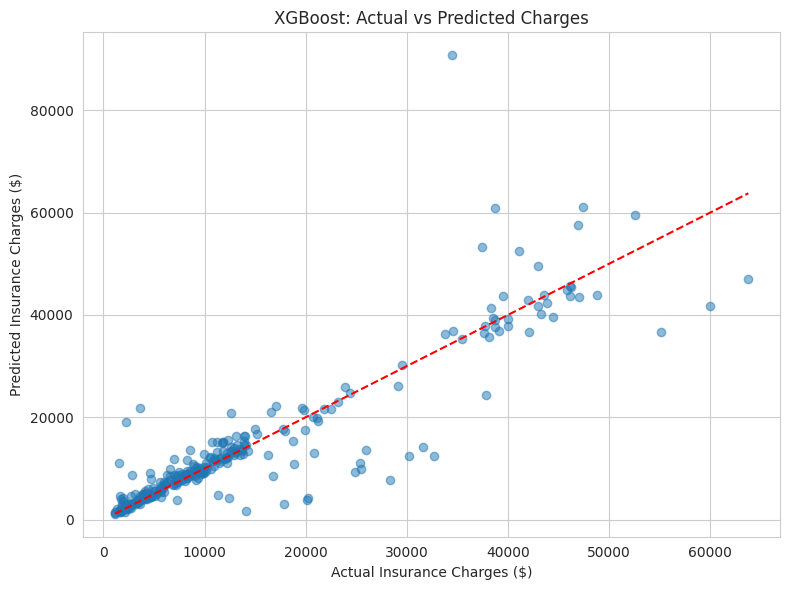

In [40]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"XGBoost RMSE (log scale): {rmse:.4f}")
print(f"XGBoost R²: {r2:.4f}")

# Calculate original scale values if using log transform
if 'log_charges' in insurance_model.columns:
    y_test_orig = np.exp(y_test)
    y_pred_orig = np.exp(y_pred)

    # Calculate metrics on original scale
    rmse_orig = sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2_orig = r2_score(y_test_orig, y_pred_orig)
    print(f"XGBoost RMSE (original scale): ${rmse_orig:.2f}")
    print(f"XGBoost R² (original scale): {r2_orig:.4f}")

# Visualize feature importance
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
if 'log_charges' in insurance_model.columns:
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
    plt.plot([min(y_test_orig), max(y_test_orig)],
             [min(y_test_orig), max(y_test_orig)], 'r--')
    plt.xlabel('Actual Insurance Charges ($)')
    plt.ylabel('Predicted Insurance Charges ($)')
else:
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual log(Insurance Charges)')
    plt.ylabel('Predicted log(Insurance Charges)')
plt.title('XGBoost: Actual vs Predicted Charges')
plt.tight_layout()
plt.savefig('xgboost_predictions.png')
plt.show()

## Neural Network

X_train_preprocessed dtype: <class 'numpy.ndarray'>
X_train_preprocessed shape: (1069, 14)
y_train dtype: float64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 86.0154 - mae: 9.2325 - val_loss: 74.5771 - val_mae: 8.5997
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 70.1983 - mae: 8.3375 - val_loss: 44.5816 - val_mae: 6.6465
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 33.4416 - mae: 5.6153 - val_loss: 3.6874 - val_mae: 1.6516
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3107 - mae: 1.4534 - val_loss: 1.5234 - val_mae: 0.9653
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8509 - mae: 1.0802 - val_loss: 1.2088 - val_mae: 0.8629
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2605 - mae: 0.8814 - val_loss: 1.0034 - val_mae: 0.7930
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0959 - mae: 0.8056 - val_loss: 0.8578 - val_mae: 0.7193
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9137 - mae: 0.7424 - val_loss: 0.7198 - val_mae: 0.6520
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

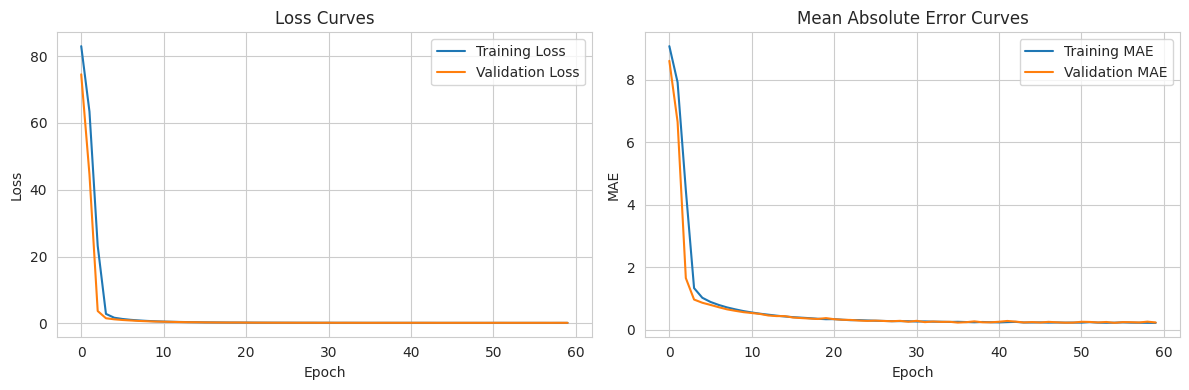

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean Squared Error (MSE): 0.1265
Root Mean Squared Error (RMSE): 0.3557
Mean Absolute Error (MAE): 0.2324
R² Score: 0.8637


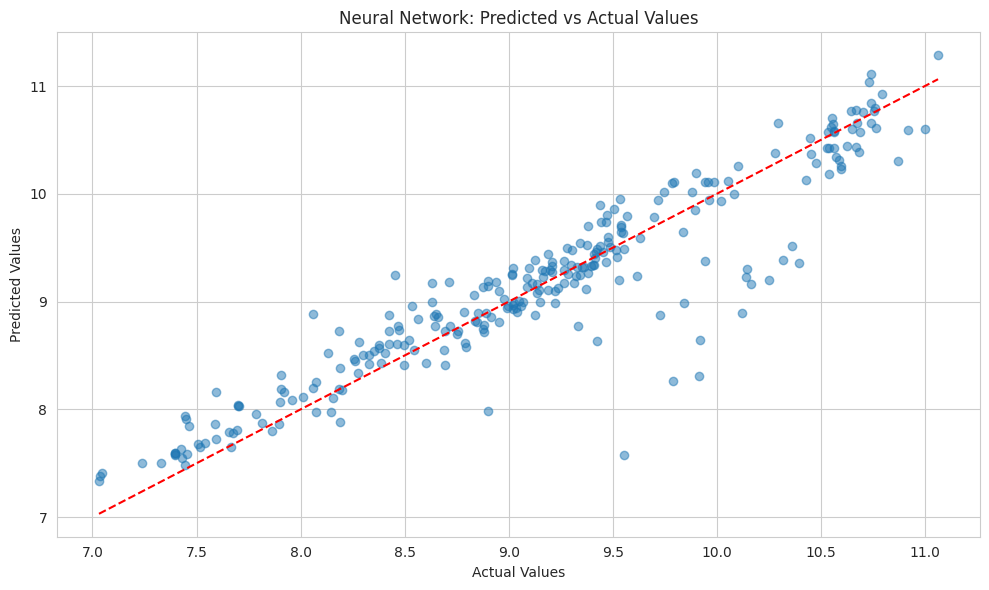

In [41]:
# Apply the preprocessing pipeline to transform the features
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Check data types before feeding to the model
print("X_train_preprocessed dtype:", type(X_train_preprocessed))
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("y_train dtype:", y_train.dtype)

# Convert y_train to numpy array if it's a pandas Series
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test

# Ensure they're float32 (TensorFlow's preferred dtype)
X_train_preprocessed = X_train_preprocessed.astype(np.float32)
y_train_np = y_train_np.astype(np.float32)
X_test_preprocessed = X_test_preprocessed.astype(np.float32)
y_test_np = y_test_np.astype(np.float32)

# Define neural network model architecture
def build_neural_network(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=[input_shape]),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1)
    ])

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )

    return model

# Build the model
input_shape = X_train_preprocessed.shape[1]
nn_model = build_neural_network(input_shape)
nn_model.summary()

# Train the model with early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train_preprocessed, y_train_np,  # Using numpy array instead of pandas
    validation_split=0.2,
    callbacks=[early_stopping],
    epochs=100,
    batch_size=32,
    verbose=1
)

# Plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error Curves')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions and evaluate model performance
y_pred = nn_model.predict(X_test_preprocessed)

# Calculate metrics
mse = mean_squared_error(y_test_np, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network: Predicted vs Actual Values')
plt.tight_layout()
plt.show()

# Model Fine-tuning

## Fine-tuning for Linear Regression

In [42]:
# Original Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
lin_rmse = sqrt(mean_squared_error(y_test, y_pred_lin))
lin_r2 = r2_score(y_test, y_pred_lin)
print(f"Linear Regression - RMSE: {lin_rmse:.4f}, R²: {lin_r2:.4f}")

# Ridge Regression (L2)
ridge_alphas = np.logspace(-3, 3, 7)  # Reduced number of alpha values
ridge_cv = GridSearchCV(Ridge(), {'alpha': ridge_alphas}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
ridge = Ridge(alpha=ridge_cv.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
ridge_rmse = sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Ridge (α={ridge_cv.best_params_['alpha']:.4f}) - RMSE: {ridge_rmse:.4f}")

# Lasso Regression (L1)
lasso_alphas = np.logspace(-4, 0, 7)  # Reduced number of alpha values
lasso_cv = GridSearchCV(Lasso(max_iter=5000), {'alpha': lasso_alphas}, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)
lasso = Lasso(alpha=lasso_cv.best_params_['alpha'], max_iter=5000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso_rmse = sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Lasso (α={lasso_cv.best_params_['alpha']:.4f}) - RMSE: {lasso_rmse:.4f}")

# Print best model based on RMSE
models = {'Linear': lin_rmse, 'Ridge': ridge_rmse, 'Lasso': lasso_rmse}
best_model = min(models.items(), key=lambda x: x[1])[0]
print(f"\nBest model: {best_model}")

Linear Regression - RMSE: 0.3398, R²: 0.8756
Ridge (α=0.0010) - RMSE: 0.3398
Lasso (α=0.0001) - RMSE: 0.3399

Best model: Linear


## Fine-tuning for Random Forest

In [43]:
# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Baseline model
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_base.fit(X_train_preprocessed, y_train_np)
y_pred_base = rf_base.predict(X_test_preprocessed)
base_rmse = sqrt(mean_squared_error(y_test_np, y_pred_base))
print(f"Baseline RF - RMSE: {base_rmse:.4f}")

# Parameter search
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=15,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

random_search.fit(X_train_preprocessed, y_train_np)
print(f"Best parameters: {random_search.best_params_}")

# Final model with best parameters
best_rf = RandomForestRegressor(**random_search.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train_preprocessed, y_train_np)
y_pred_best = best_rf.predict(X_test_preprocessed)
best_rmse = sqrt(mean_squared_error(y_test_np, y_pred_best))

print(f"Tuned RF - RMSE: {best_rmse:.4f}")
print(f"Improvement: {((base_rmse - best_rmse) / base_rmse * 100):.2f}% reduction in RMSE")

Baseline RF - RMSE: 0.3730
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}
Tuned RF - RMSE: 0.3324
Improvement: 10.89% reduction in RMSE


## Fine-tuning for XGBoost

In [44]:
from sklearn.model_selection import GridSearchCV

# Define focused parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Run grid search
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# Train tuned model
best_xgb = grid_search.best_estimator_
best_pred = best_xgb.predict(X_test)
best_rmse = sqrt(mean_squared_error(y_test, best_pred))
best_r2 = r2_score(y_test, best_pred)

print(f"Tuned XGBoost - RMSE: {best_rmse:.4f}, R²: {best_r2:.4f}")


# Calculate original scale metrics
if 'log_charges' in insurance_model.columns:
    y_test_orig = np.exp(y_test)
    best_pred_orig = np.exp(best_pred)
    best_rmse_orig = sqrt(mean_squared_error(y_test_orig, best_pred_orig))
    best_r2_orig = r2_score(y_test_orig, best_pred_orig)
    print(f"Tuned XGBoost (original $) - RMSE: ${best_rmse_orig:.2f}, R²: {best_r2_orig:.4f}")

# Compare with original model
improvement = ((rmse - best_rmse) / rmse) * 100
print(f"Performance improvement: {improvement:.2f}%")

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost - RMSE: 0.3243, R²: 0.8867
Tuned XGBoost (original $) - RMSE: $4437.53, R²: 0.8928
Performance improvement: 8.81%


## Fine-tuning for Neural Network

Starting hyperparameter tuning for Neural Network...

Params: neurons=32, lr=0.01, batch_size=16 => Val RMSE: 0.3660, Val R²: 0.8410
Params: neurons=32, lr=0.01, batch_size=32 => Val RMSE: 0.3755, Val R²: 0.8326
Params: neurons=32, lr=0.001, batch_size=16 => Val RMSE: 0.3920, Val R²: 0.8176
Params: neurons=32, lr=0.001, batch_size=32 => Val RMSE: 0.4088, Val R²: 0.8016
Params: neurons=32, lr=0.0001, batch_size=16 => Val RMSE: 0.9001, Val R²: 0.0384
Params: neurons=32, lr=0.0001, batch_size=32 => Val RMSE: 1.1931, Val R²: -0.6896
Params: neurons=64, lr=0.01, batch_size=16 => Val RMSE: 0.3884, Val R²: 0.8209
Params: neurons=64, lr=0.01, batch_size=32 => Val RMSE: 0.3871, Val R²: 0.8222
Params: neurons=64, lr=0.001, batch_size=16 => Val RMSE: 0.3930, Val R²: 0.8167
Params: neurons=64, lr=0.001, batch_size=32 => Val RMSE: 0.3744, Val R²: 0.8336
Params: neurons=64, lr=0.0001, batch_size=16 => Val RMSE: 0.7163, Val R²: 0.3909
Params: neurons=64, lr=0.0001, batch_size=32 => Val RMSE: 1.0138, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


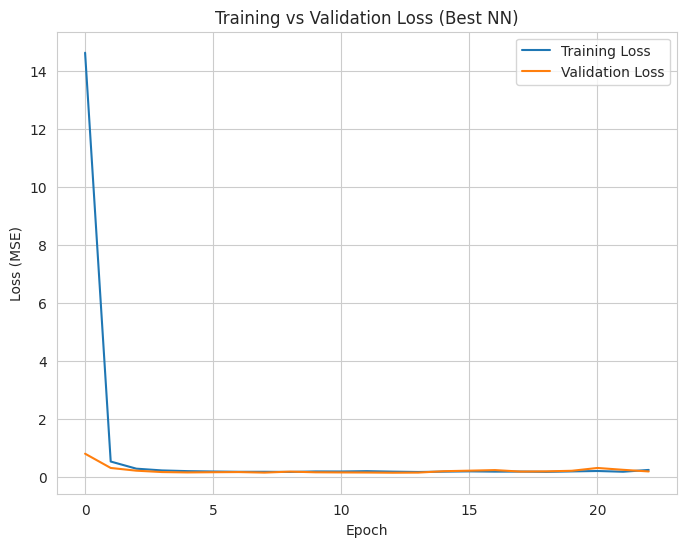


Test Set Performance of Best NN:
Test RMSE: 0.3770
Test R²: 0.8469

Starting 5-Fold Cross Validation with Best Hyperparameters...

Fold 1 => RMSE: 0.3964, R²: 0.8017
Fold 2 => RMSE: 0.4038, R²: 0.8148
Fold 3 => RMSE: 0.3590, R²: 0.8463
Fold 4 => RMSE: 0.4498, R²: 0.7227
Fold 5 => RMSE: 0.3887, R²: 0.8232

Average Cross-Validated RMSE: 0.3995
Average Cross-Validated R²: 0.8018


In [45]:
X_train_preprocessed = preprocessor.fit_transform(X_train).astype(np.float32)
X_test_preprocessed = preprocessor.transform(X_test).astype(np.float32)
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Define hyperparameter options
neurons_options = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32]

# Create a simple validation split for tuning
val_split = 0.2
val_idx = int(len(X_train_preprocessed) * (1 - val_split))
X_train_part = X_train_preprocessed[:val_idx]
y_train_part = y_train_np[:val_idx]
X_val = X_train_preprocessed[val_idx:]
y_val = y_train_np[val_idx:]

# Get the input shape for the neural network
input_shape = X_train_preprocessed.shape[1]

best_rmse = float('inf')
best_params = {}

print("Starting hyperparameter tuning for Neural Network...\n")
for neurons in neurons_options:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Build the model
            inputs = keras.Input(shape=(input_shape,))
            x = keras.layers.Dense(neurons, activation='relu')(inputs)
            x = keras.layers.Dense(neurons // 2, activation='relu')(x)
            x = keras.layers.Dense(16, activation='relu')(x)
            outputs = keras.layers.Dense(1)(x)
            model = keras.Model(inputs=inputs, outputs=outputs)

            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mae']
            )

            # Train with early stopping
            early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
            model.fit(
                X_train_part, y_train_part,
                epochs=50,
                batch_size=batch_size,
                callbacks=[early_stopping],
                validation_data=(X_val, y_val),
                verbose=0
            )

            # Evaluate on the validation set
            val_pred = model.predict(X_val, verbose=0)
            val_rmse = sqrt(mean_squared_error(y_val, val_pred))
            val_r2 = r2_score(y_val, val_pred)

            print(f"Params: neurons={neurons}, lr={lr}, batch_size={batch_size} => Val RMSE: {val_rmse:.4f}, Val R²: {val_r2:.4f}")

            # Update best parameters based on RMSE
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_params = {'neurons': neurons, 'lr': lr, 'batch_size': batch_size}

print("\nBest hyperparameters found:")
print(best_params)
print(f"Best Validation RMSE: {best_rmse:.4f}")

# Retrain the Model with Best Hyperparameters using the entire training set
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
best_model = keras.Sequential([
    keras.layers.Dense(best_params['neurons'], activation='relu', input_shape=(input_shape,)),
    keras.layers.Dense(best_params['neurons'] // 2, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_params['lr']),
    loss='mse',
    metrics=['mae']
)

print("\nTraining final model with best hyperparameters...")
history = best_model.fit(
    X_train_preprocessed, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=0
)

# Plot the loss curves for the best model
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss (Best NN)')
plt.legend()
plt.show()

# Evaluate on the test set
y_test_pred = best_model.predict(X_test_preprocessed, verbose=0)
test_rmse = sqrt(mean_squared_error(y_test_np, y_test_pred))
test_r2 = r2_score(y_test_np, y_test_pred)
print(f"\nTest Set Performance of Best NN:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# K-Fold Cross Validation with Best Params
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_rmse_list = []
cv_r2_list = []
fold = 1

print("\nStarting 5-Fold Cross Validation with Best Hyperparameters...\n")
for train_index, val_index in kf.split(X_train_preprocessed):
    X_cv_train, X_cv_val = X_train_preprocessed[train_index], X_train_preprocessed[val_index]
    y_cv_train, y_cv_val = y_train_np[train_index], y_train_np[val_index]

    # Build model with best hyperparameters
    inputs = keras.Input(shape=(input_shape,))
    x = keras.layers.Dense(best_params['neurons'], activation='relu')(inputs)
    x = keras.layers.Dense(best_params['neurons'] // 2, activation='relu')(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    outputs = keras.layers.Dense(1)(x)
    model_cv = keras.Model(inputs=inputs, outputs=outputs)

    model_cv.compile(
        optimizer=keras.optimizers.Adam(learning_rate=best_params['lr']),
        loss='mse',
        metrics=['mae']
    )

    early_stopping_cv = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    model_cv.fit(
        X_cv_train, y_cv_train,
        epochs=100,
        batch_size=best_params['batch_size'],
        callbacks=[early_stopping_cv],
        validation_data=(X_cv_val, y_cv_val),
        verbose=0,
    )

    y_cv_pred = model_cv.predict(X_cv_val, verbose=0)
    cv_rmse = sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_r2 = r2_score(y_cv_val, y_cv_pred)
    cv_rmse_list.append(cv_rmse)
    cv_r2_list.append(cv_r2)
    print(f"Fold {fold} => RMSE: {cv_rmse:.4f}, R²: {cv_r2:.4f}")
    fold += 1

avg_cv_rmse = sum(cv_rmse_list) / n_splits
avg_cv_r2 = sum(cv_r2_list) / n_splits
print(f"\nAverage Cross-Validated RMSE: {avg_cv_rmse:.4f}")
print(f"Average Cross-Validated R²: {avg_cv_r2:.4f}")